In [32]:
import os
import fitsio
import desimodel
import pandas as pd
import pylab as pl
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   datetime import datetime
from   astropy.table import Table, vstack, join
from   desimodel.footprint import is_point_in_desi
from   desimodel import io
from   desitarget.geomask import circles
from   desitarget.targetmask import desi_mask, obsconditions

In [15]:
def laigle():
  f      = open('/global/homes/m/mjwilson/DESILBG/target/proposals/laigle/cosmos_zphot_mag25.tbl', 'r')

  line   = f.readline()

  names  = [x for x in line.split() if x != '|'] 

  names  = [x.replace('|', '') for x in names][1:]

  laigle = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/laigle/cosmos_zphot_mag25.tbl', comment='#', sep='\s+', names=names)

  # laigle = laigle[np.isfinite(laigle['zp_best'])]

  # isin = (laigle['zp_best'] > 1.8) & (laigle['zp_best'] < 5.0) & (laigle['imag'] < 24.0)

  return laigle # [isin]

In [20]:
def get_kids(field='G9'):
    # fields = ['G9', 'G12', 'G15']
    
    kids = Table() 
    
    kids = vstack((kids, Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/kids/KiDS_DR3.1_{}_ugri_shear.fits'.format(field))))                  
    
    kids = fitsio.read('/global/homes/m/mjwilson/DESILBG/target/proposals/kids/KiDS_DR3.1_{}_ugri_shear.fits'.format(field))
    
    return  Table(kids)

In [4]:
def get_hildebrandt():
    D2   = Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/D2.cat')
    
    return  D2

In [2]:
# hiz  = laigle()

In [3]:
# kids = get_kids()

In [5]:
hilde = get_hildebrandt()

In [6]:
hilde

<Table length=448358>
FIELD_POS SeqNr   FLUX_ISO  ... r_i_ISO_cor2 r_z_ISO_cor2 i_z_ISO_cor2
                     ct     ...                                       
  int16   int32   float32   ...   float32      float32      float32   
--------- ------ ---------- ... ------------ ------------ ------------
        1      1  2.5917673 ...   -0.1036579   0.49070683    0.5943647
        1      2  1.7266549 ...    0.4200354   0.86109406   0.44105873
        1      3  7.3484426 ...    0.3817086     0.155334  -0.22637461
        1      4   78.01947 ...   0.43654242    0.6593161    0.2227737
        1      5  18.292309 ...   0.63722163    1.2427503    0.6055287
        1      6   62.52823 ...    0.0737475    0.4102736   0.33652613
        1      7  7.8252273 ...   -0.0465744 -0.011938099    0.0346363
        1      8  11.494217 ...   0.47735682    0.7382518     0.260895
        1      9  5.1442766 ...    0.5177568    1.1652517   0.64749503
      ...    ...        ... ...          ...          ...          ...
        1 448349   4.297287 ...    0.1582273    0.2908262   0.13259889
        1 448350 0.30944726 ... -0.008759401   0.06585161   0.07461101
        1 448351  1.2162051 ...    0.4512531    0.9554495   0.50419647
        1 448352    1.74643 ...   0.32337308    0.8206876    0.4973145
        1 448353  3.9715576 ...    0.6455931    0.9904258   0.34483284
        1 448354  13.352117 ...   0.88405937    1.3657438   0.48168454
        1 448355 0.68173856 ...    0.8903238    1.4150974    0.5247736
        1 448356  0.2637093 ...    0.1684463    1.0508275    0.8823813
        1 448357  28.248909 ...   0.52520716    0.8116788    0.2864717
        1 448358  0.6190345 ...    0.7338399   0.89542407    0.1615842

In [47]:
def drops(dband='u'):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = hilde['CLASS_STAR'] < 0.9 
    isin &= hilde['maskgscw']   ==   0
    isin &= hilde['masksa']     ==   0    
    isin &= hilde['MASK_STARS'] ==   0
    isin &= hilde['MASK_u']     ==   0
    isin &= hilde['MASK_g']     ==   0
    isin &= hilde['MASK_r']     ==   0
    isin &= hilde['MASK_i']     ==   0
    isin &= hilde['MASK_z']     ==   0
    
    if dband == 'BX':
        # LATIS, https://arxiv.org/pdf/2002.10676.pdf
        # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
        isin &= hilde['u_g_ISO_cor2'] >  0.5
        isin &= hilde['u_g_ISO_cor2'] <  2.2
        isin &= hilde['g_r_ISO_cor2'] > -0.1
        isin &= hilde['g_r_ISO_cor2'] <  1.0
        isin &= hilde['u_g_ISO_cor2'] > 0.5 + 2.3 * (hilde['g_r_ISO_cor2'] - 0.35)
    
    elif dband == 'u':
      # u drops.
      # 1.5 < (u − g) and −1.0 < (g − r) < 1.2 and 1.5 · (g − r) < (u − g) − 0.75    
      isin &= hilde['u_g_ISO_cor2'] >  1.5
      isin &= hilde['g_r_ISO_cor2'] > -1.0
      isin &= hilde['g_r_ISO_cor2'] <  1.2
      isin &= 1.5 * hilde['g_r_ISO_cor2'] <  hilde['u_g_ISO_cor2'] - 0.75

    elif dband == 'g':
      # g drops
      # 1.0 < (g − r) and −1.0 < (r − i) < 1.0 and 1.5 · (r − i) < (g − r) − 0.8
      isin &= hilde['g_r_ISO_cor2'] >  1.0
      isin &= hilde['r_i_ISO_cor2'] > -1.0
      isin &= hilde['r_i_ISO_cor2'] <  1.0
      isin &= 1.5 * hilde['r_i_ISO_cor2'] < hilde['g_r_ISO_cor2'] - 0.80
    
    else:
        raise ValueError('dband of {} is not supported; try [u, g].'.format(dband))
    
    return  isin        

In [48]:
xdrops = drops(dband='BX')
udrops = drops(dband='u')
gdrops = drops(dband='g')

adrops = xdrops | udrops | gdrops

In [49]:
xdrops = hilde[xdrops]
udrops = hilde[udrops]
gdrops = hilde[gdrops]

adrops = hilde[adrops]

(-1.0, 4.0)

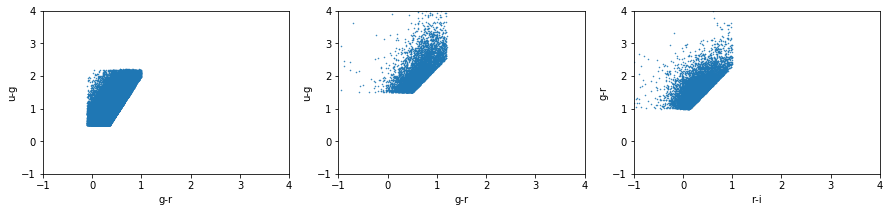

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 

axes[0].plot(xdrops['g_r_ISO_cor2'], xdrops['u_g_ISO_cor2'], marker='.', lw=0.0, markersize=1.)

axes[0].set_xlabel('g-r')
axes[0].set_ylabel('u-g')

axes[0].set_xlim(-1., 4.)
axes[0].set_ylim(-1., 4.)

axes[1].plot(udrops['g_r_ISO_cor2'], udrops['u_g_ISO_cor2'], marker='.', lw=0.0, markersize=1.)

axes[1].set_xlabel('g-r')
axes[1].set_ylabel('u-g')

axes[1].set_xlim(-1., 4.)
axes[1].set_ylim(-1., 4.)

axes[2].plot(gdrops['r_i_ISO_cor2'], gdrops['g_r_ISO_cor2'], marker='.', lw=0.0, markersize=1.)

axes[2].set_xlabel('r-i')
axes[2].set_ylabel('g-r')

axes[2].set_xlim(-1., 4.)
axes[2].set_ylim(-1., 4.)

In [19]:
# sample.dtype.names

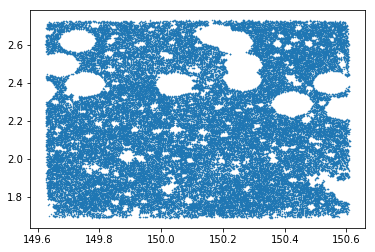

In [51]:
pl.plot(adrops['ALPHA_J2000'], adrops['DELTA_J2000'], marker='.', markersize=1, lw=0.0)

In [52]:
tiles = io.load_tiles()

In [54]:
isin, indx  = is_point_in_desi(tiles, adrops['ALPHA_J2000'], adrops['DELTA_J2000'], radius=None, return_tile_index=True)

In [56]:
print('Fraction of KIDS-GAMA in desi: {}'.format(100. * np.count_nonzero(isin) / len(adrops)))

Fraction of KIDS-GAMA in desi: 100.0


In [57]:
print('Number of unique DESI tiles: {}'.format(len(np.unique(indx))))

Number of unique DESI tiles: 4


In [58]:
tile_radius = desimodel.focalplane.get_tile_radius_deg()

print('Radius of DESI tile: {} [deg.]'.format(tile_radius))

Radius of DESI tile: 1.6280324520485583 [deg.]


In [59]:
# sample           = hiz.to_numpy()
# sample           = Table(sample, names=names)

In [60]:
sample             = adrops

In [62]:
sample['TILEID']   = tiles[indx]['TILEID']

sample['TARGETID'] = np.array(range(len(sample)))
sample['RA']       = sample['ALPHA_J2000']
sample['DEC']      = sample['DELTA_J2000']

sample['DESI_TARGET'] = desi_mask.ELG
sample['BGS_TARGET']  = np.zeros(len(sample), dtype='i8')
sample['MWS_TARGET']  = np.zeros(len(sample), dtype='i8')

# ELG -like
sample['PRIORITY'] = 9999
sample['SUBPRIORITY'] = np.random.uniform(0, 1, len(sample))
sample['BRICKNAME'] = np.full(len(sample), '000p0000')    #- required !?!
sample['BRICKID'] = np.full(len(sample), 0)    #- required !?!
sample['BRICK_OBJID'] = np.arange(len(sample))

sample['OBSCONDITIONS'] = np.ones(len(sample), dtype='i4') * obsconditions.DARK
sample['NUMOBS_MORE'] = np.ones(len(sample), dtype='i8')

#- dummy values for fluxes
for filt in ['G', 'R', 'Z']:
    sample['FIBERFLUX_'+filt] = np.zeros(len(sample), dtype='f4')
    sample['FIBERFLUX_IVAR_'+filt] = np.ones(len(sample), dtype='f4')
        
sample.meta['EXTNAME'] = 'MTL'

In [63]:
sample

<Table length=65713>
FIELD_POS SeqNr   FLUX_ISO  ... FIBERFLUX_IVAR_R FIBERFLUX_Z FIBERFLUX_IVAR_Z
                     ct     ...                                              
  int16   int32   float32   ...     float32        float32       float32     
--------- ------ ---------- ... ---------------- ----------- ----------------
        1   1262   1.192389 ...              1.0         0.0              1.0
        1   1323  4.3666077 ...              1.0         0.0              1.0
        1   1334 0.81718355 ...              1.0         0.0              1.0
        1   1347 0.37020895 ...              1.0         0.0              1.0
        1   1371  0.8206514 ...              1.0         0.0              1.0
        1   1380   8.779715 ...              1.0         0.0              1.0
        1   1423 0.45158318 ...              1.0         0.0              1.0
        1   1505  1.1348187 ...              1.0         0.0              1.0
        1   1540  2.9686406 ...              1.0         0.0              1.0
      ...    ...        ... ...              ...         ...              ...
        1 448280  1.8157974 ...              1.0         0.0              1.0
        1 448285 0.22201452 ...              1.0         0.0              1.0
        1 448288 0.76277846 ...              1.0         0.0              1.0
        1 448290  1.9248856 ...              1.0         0.0              1.0
        1 448293 0.36708528 ...              1.0         0.0              1.0
        1 448302 0.27100605 ...              1.0         0.0              1.0
        1 448309 0.37480655 ...              1.0         0.0              1.0
        1 448334 0.36435458 ...              1.0         0.0              1.0
        1 448350 0.30944726 ...              1.0         0.0              1.0
        1 448358  0.6190345 ...              1.0         0.0              1.0

In [64]:
np.unique(indx, return_counts=True)

(array([ 3754,  5752,  9749, 12816]), array([62947,   322,  1910,   534]))

In [65]:
tiles[3754]['TILEID'], np.count_nonzero(indx == 3754)

(11155, 62947)

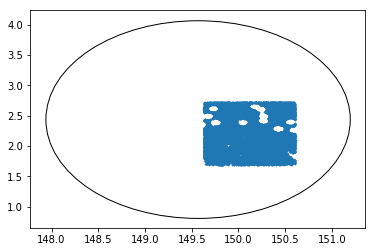

In [94]:
circles(tiles['RA'][3754], tiles['DEC'][3754], tile_radius, c='k', fc='w')

pl.plot(adrops['ALPHA_J2000'], adrops['DELTA_J2000'], marker='.', markersize=1, lw=0.0)

Text(0,0.5,'$N$ / sq. deg.')

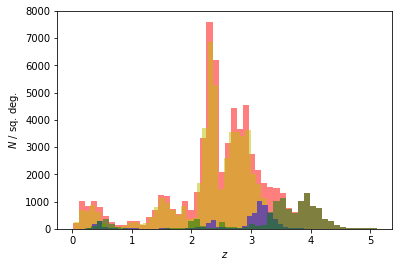

In [89]:
_ = pl.hist(adrops['Z_PHOT'], bins=50, alpha=0.5, color='r')
_ = pl.hist(xdrops['Z_PHOT'], bins=50, alpha=0.5, color='y')
_ = pl.hist(udrops['Z_PHOT'], bins=50, alpha=0.5, color='b')
_ = pl.hist(gdrops['Z_PHOT'], bins=50, alpha=0.5, color='g')

pl.xlabel('$z$')
pl.ylabel('$N$ / sq. deg.')

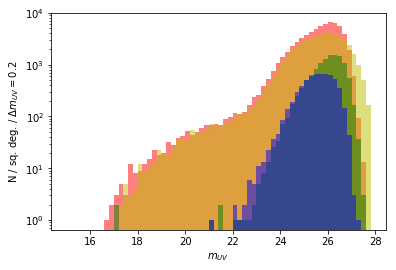

In [90]:
bins = np.arange(15., 28., 0.2)

_ = pl.hist(adrops['MAG_ISOCOR_i'], bins=bins, alpha=0.5, color='r')
_ = pl.hist(xdrops['MAG_ISOCOR_r'], bins=bins, alpha=0.5, color='y')
_ = pl.hist(gdrops['MAG_ISOCOR_i'], bins=bins, alpha=0.5, color='g')
_ = pl.hist(udrops['MAG_ISOCOR_r'], bins=bins, alpha=0.5, color='b')

pl.xlabel('$m_{UV}$')
pl.ylabel('N / sq. deg. / $\Delta m_{UV} = 0.2$')

pl.yscale('log')

In [91]:
tsample = adrops[adrops['TILEID'] == 11155]

In [92]:
len(tsample)

62947

In [99]:
# Construct a bright sample.

In [98]:
tsample.write('/global/homes/m/mjwilson/DESILBG/target/proposals/indata/CFHTLSD2_mtl.fits', overwrite=True)

In [101]:
targetlist                = Table()

targetlist['RA']          = np.array(tsample['ALPHA_J2000'],   dtype='>f8')
targetlist['DEC']         = np.array(tsample['DELTA_J2000'],  dtype='>f8')

targetlist['PMRA']        = np.zeros(len(tsample),   dtype='>f4')
targetlist['PMDEC']       = np.zeros(len(tsample),   dtype='>f4')

targetlist['REF_EPOCH']   = np.zeros(len(tsample),   dtype='>f4')
targetlist['OVERRIDE']    = np.zeros(len(tsample),   dtype='>f4')

targetlist['PRIORITY']    = tsample['PRIORITY']
targetlist['SUBPRIORITY'] = tsample['SUBPRIORITY']
targetlist['TILEID']      = tsample['TILEID']

targetlist.sort('PRIORITY')
targetlist                = targetlist[::-1]

In [102]:
targetlist

<Table length=62947>
        RA                DEC           PMRA  ...     SUBPRIORITY     TILEID
     float64            float64       float32 ...       float64       int32 
------------------ ------------------ ------- ... ------------------- ------
 150.0783422370338   2.71999640025289     0.0 ...  0.1432875333227982  11155
150.40211406036994 2.0145074937024616     0.0 ... 0.30564024288809677  11155
150.41529262851236 2.0123573513644706     0.0 ...  0.5748425871430215  11155
 149.6341363941429  2.014451257060388     0.0 ...   0.322801021883396  11155
149.63155048145603  2.014459792161416     0.0 ... 0.17493282160684276  11155
150.18290912288526  2.014433804454465     0.0 ... 0.36864836699836556  11155
149.95929215466222 2.0126781605472712     0.0 ...  0.9093726224538823  11155
150.12953002370335 2.0144292998046573     0.0 ...  0.3645510786677767  11155
 149.8360092372938 2.0144063745709255     0.0 ...   0.517861050247395  11155
 149.9476900707624 2.0141814096148507     0.0 ...   0.590796663012254  11155
               ...                ...     ... ...                 ...    ...
149.78895926167735 2.3131418917264295     0.0 ... 0.30650028184802236  11155
149.79851173423006  2.312955542802651     0.0 ...   0.189365265309837  11155
149.66007328533425 2.3131060294217725     0.0 ...  0.9458541521712128  11155
150.54658824860198 2.3130427899521404     0.0 ...   0.477422108925436  11155
150.26056256172518  2.313153778704488     0.0 ...  0.8763925436201041  11155
150.13594007933307 2.3131364381110404     0.0 ...  0.1898147339179458  11155
149.66786648179058 2.3129777940310743     0.0 ...   0.993560283688103  11155
149.76571956584047 2.3130751333389634     0.0 ...   0.804395020983719  11155
150.50562219370985  2.313018819143227     0.0 ...    0.68919853283866  11155
150.35130327510882 1.6887912556158113     0.0 ...    0.12827807328341  11155

In [104]:
targetlist.write('/global/homes/m/mjwilson/DESILBG/target/proposals/indata/LBGLAE.fits', overwrite=True)

In [88]:
skies = fitsio.read('/global/cfs/cdirs/desi/target/catalogs/dr8/0.32.0/skies/skies-dr8-0.32.0.fits')

In [89]:
stds  = fitsio.read('/global/cfs/cdirs/desi/target/catalogs/dr8/0.32.0/gfas/gfas-dr8-0.32.0.fits')

In [90]:
indx = np.unique(indx)

In [91]:
tiles = tiles[indx]

In [92]:
len(tiles)

5

In [93]:
tiles = Table(tiles)

In [94]:
tiles

<Table length=5>
TILEID         RA                DEC         ... IMAGEFRAC_GRZ IN_IMAGING
int32       float64            float64       ...    float32     float32  
------ ------------------ ------------------ ... ------------- ----------
 11155 149.56274790593744 2.4436393426872773 ...     0.9980314        1.0
 16917 149.08706521046741 1.3760331911464574 ...     0.9977611        1.0
 22679              149.0               2.21 ...      0.997906        1.0
 28442 151.50283229883524 2.6861000957903527 ...     0.9982405        1.0
 36640 150.40735609981076 0.5742273703759129 ...     0.9981242        1.0

In [95]:
for i in range(len(tiles)):
    Table(tiles[i]).write('/global/homes/m/mjwilson/target/proposals/tiles/tiles_{}.fits'.format(tiles['TILEID'][i]), overwrite=True)

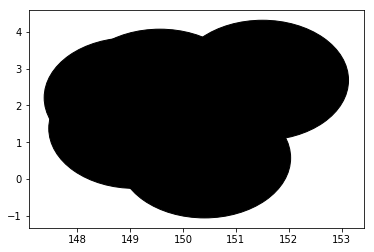

In [96]:
circles(tiles['RA'], tiles['DEC'], tile_radius, c='k')

In [97]:
tiles      = tiles[tiles['TILEID'] == 11155]

In [98]:
nskies     = skies[is_point_in_desi(tiles, skies['RA'], skies['DEC'], radius=None, return_tile_index=False)]

In [99]:
Table(nskies).write('/global/homes/m/mjwilson/target/proposals/tiles/skies_11155.fits', format='fits', overwrite=True)

In [100]:
nstds      = stds[is_point_in_desi(tiles, stds['RA'], stds['DEC'], radius=None, return_tile_index=False)]

In [101]:
nstds                  = Table(nstds)
nstds['SUBPRIORITY']   = np.random.uniform(0, 1, len(nstds))
nstds['OBSCONDITIONS'] = np.ones(len(nstds), dtype='i4') * obsconditions.DARK
nstds['DESI_TARGET']   = desi_mask.STD_FAINT

In [102]:
nstds                  = nstds[nstds['TARGETID'] > 0]

In [103]:
np.unique(nstds['TARGETID'], return_counts=True)

(<Column name='TARGETID' dtype='int64' length=19773>
 35185778371858383
 35185778371858510
 35185778371858517
 35185778371858592
 35185778371858631
 35185778371858658
 35185778371858677
 35185778371858684
 35185778371858688
 35185778376052963
 35185778376053018
 35185778376053326
               ...
 35185856876644839
 35185856880836706
 35185856880836826
 35185856880836995
 35185856880837223
 35185856880837274
 35185856880837334
 35185856880837418
 35185856880837434
 35185856880837462
 35185856880837537
 35185856880837725, array([1, 1, 1, ..., 1, 1, 1]))

In [104]:
nstds.write('/global/homes/m/mjwilson/target/proposals/tiles/stds_11155.fits', format='fits', overwrite=True)

In [105]:
rundatestr = "2020-01-01T00:00:00"
rundate    = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S")

rundate

datetime.datetime(2020, 1, 1, 0, 0)

In [112]:
cmd  = 'fiberassign --overwrite --mtl /global/homes/m/mjwilson/DESILBG/target/proposals/indata/CFHTLSD2_mtl.fits' 
cmd += ' --stdstar /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/stds_11155.fits' 
cmd += ' --sky /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/skies_11155.fits'
cmd += ' --rundate {}'.format(rundatestr)
cmd += ' --footprint /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/tiles_11155.fits'
cmd += ' --outdir /global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/'

In [113]:
print(cmd)

fiberassign --overwrite --mtl /global/homes/m/mjwilson/DESILBG/target/proposals/indata/CFHTLSD2_mtl.fits --stdstar /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/stds_11155.fits --sky /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/skies_11155.fits --rundate 2020-01-01T00:00:00 --footprint /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/tiles_11155.fits --outdir /global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/


In [114]:
os.system(cmd)

0

In [116]:
fiberassign = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/fiberassign-011155.fits')

In [117]:
fiberassign

<Table length=5000>
     TARGETID      PETAL_LOC DEVICE_LOC ... URAT_ID URAT_SEP
      int64          int16     int32    ...  int64  float32 
------------------ --------- ---------- ... ------- --------
 35185790451453248         0        311 ...     -99    -99.0
 35185790455648572         0        272 ...     -99    -99.0
 35185790455649252         0        252 ...     -99    -99.0
 35185796499639238         0        156 ...     -99    -99.0
 35185796499637696         0        198 ...     -99    -99.0
 35185796495444183         0        204 ...     -99    -99.0
611646548803059747         0        233 ...       0      0.0
 35185796495445142         0        172 ...     -99    -99.0
 35185790455647614         0        310 ...     -99    -99.0
 35185790455647788         0        290 ...     -99    -99.0
               ...       ...        ... ...     ...      ...
 35185796503833111         9        220 ...     -99    -99.0
 35185796508029304         9        188 ...     -99    -99.0
611646548807254108         9        238 ...       0      0.0
 35185796508026793         9        252 ...     -99    -99.0
611646542771650883         9        291 ...       0      0.0
 35185796508029545         9        200 ...     -99    -99.0
 35185796503831568         9        256 ...     -99    -99.0
611646548811448634         9        201 ...       0      0.0
 35185796508027971         9        234 ...     -99    -99.0
 35185802547822886         9        214 ...     -99    -99.0

In [118]:
np.unique(fiberassign['PRIORITY'], return_counts=True)

(<Column name='PRIORITY' dtype='int32' length=2>
    0
 9999, array([4430,  570]))

In [122]:
science = fiberassign[fiberassign['PRIORITY'] == 9999]

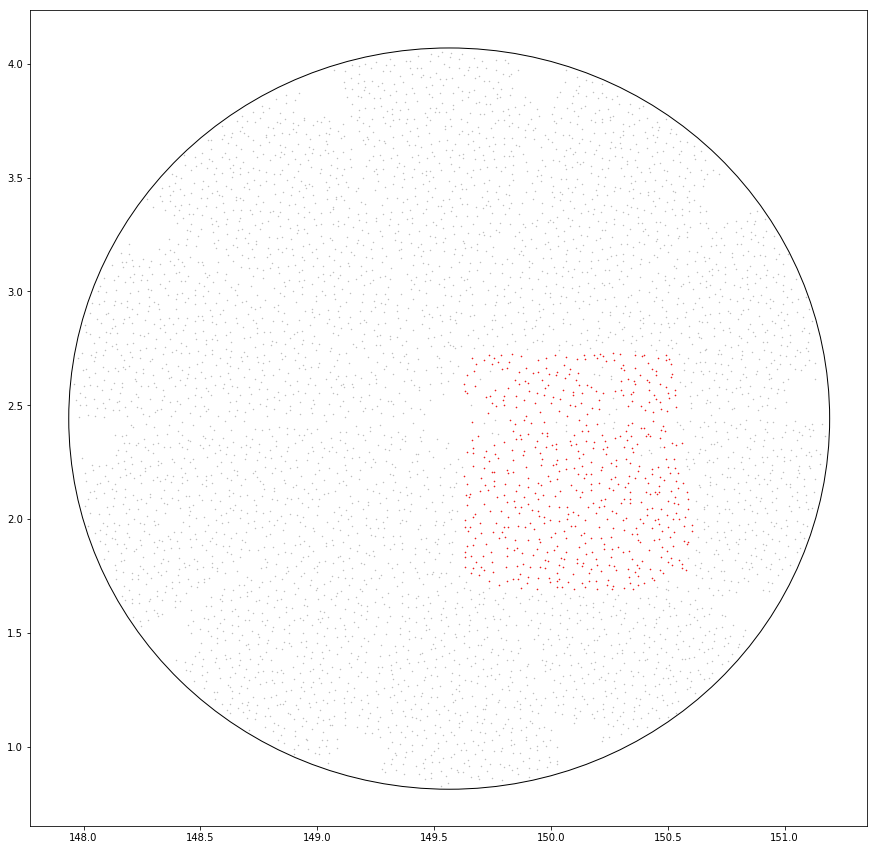

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

plt.sca(ax)

circles(tiles['RA'][3754], tiles['DEC'][3754], tile_radius, c='k', fc='w')

ax.plot(fiberassign['TARGET_RA'], fiberassign['TARGET_DEC'], marker='.', lw=0.0, markersize=1, c='k', alpha=0.25)
ax.plot(science['TARGET_RA'],         science['TARGET_DEC'], marker='.', lw=0.0, markersize=1, c='r')

In [139]:
len(science)

570

Done.